In [1]:
import pandas as pd
import numpy as np
from timesmash import XHMMFeatures, SymbolicDerivative, InferredHMMLikelihood, Quantizer, LikelihoodDistance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from patternly.detection import StreamingDetection, AnomalyDetection
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Read in data.

def fill_end_ts(df):
    def replace_nan(row):
        if pd.isnull(row["End Timestamp"]):
            row["End Timestamp"] = row["Start Timestamp"] + 60
        return row
    return df.apply(replace_nan, axis=1)


def read_in_data(session_id, df):
    original = {}
    start_ts = 0
    hz = []
    
    for category in DATA_CATEGORIES:
        file = category
        if category[0:3] == "ACC":
            file = "ACC"
        curr = pd.read_csv(f"./data/{str(session_id)[:-2]}/{file}.csv", sep=",", low_memory=False, header=None)
        if file == "ACC":
            if category[len(category) - 1] == "X":
                curr = curr.drop([1,2], axis=1)
            elif category[len(category) - 1] == "Y":
                curr = curr.drop([0,2], axis=1)
            elif category[len(category) - 1] == "Z":
                curr = curr.drop([0,1], axis=1)
        original[category] = curr
        start_ts = original[category].iloc[0,0]
        hz.append(original[category].iloc[1,0])
        original[category] = original[category].iloc[2:].reset_index(drop=True)
        
    agitation_starts, agitation_ends = df[df["Session ID"] == session_id][["Start Timestamp", "End Timestamp"]].T.values.tolist()    
        
    return original, start_ts, agitation_starts, agitation_ends, hz


agitations = pd.read_csv("./agitations.csv")
agitations = agitations[agitations["Session ID"].notna()]
patient_set = set(agitations["Patient ID"])
patients = []
for patient in patient_set:
    if agitations[agitations["Patient ID"] == patient].shape[0] >= 2:
        patients.append(patient)
        
DATA_CATEGORIES = ["ACC_X", "ACC_Y", "ACC_Z"]
DATA_CATEGORIES = ["ACC_X"]

curr_patient = '07-B-S'
curr_agitations = agitations[agitations["Patient ID"] == curr_patient]
curr_agitations = fill_end_ts(curr_agitations)

SESSION_ID_TRAIN = curr_agitations["Session ID"].iloc[0]

train_original, train_start_ts, train_agitation_starts, train_agitation_ends, hz = read_in_data(SESSION_ID_TRAIN, curr_agitations)
n_hours = 16
train_end_ts = train_start_ts + train_original[DATA_CATEGORIES[0]].shape[0] // hz[0]
new_train_start_ts = train_start_ts + (60 * 60 * 1)
new_train_end_ts = min(train_end_ts, new_train_start_ts + (60 * 60 * n_hours))
train_start_index = new_train_start_ts - train_start_ts
train_end_index = (train_end_ts - train_start_ts) - (train_end_ts - new_train_end_ts)

In [2]:
%%time

# Find first-layer PFSAs

from datetime import datetime

WINDOW_SIZE = (np.full((len(DATA_CATEGORIES)), 20) * hz).astype(np.int)
WINDOW_OVERLAP = (np.full((len(DATA_CATEGORIES)), 10) * hz).astype(np.int)
N_CLUSTERS_1 = 3
QUANTIZE_TYPE = "simple"
EPS = 0.05
VERBOSE = True

data = {}
first_layer_pipelines = []
second_layer_pipelines = []
for i, category in enumerate(DATA_CATEGORIES):
    data[category] = train_original[category].iloc[
        int(train_start_index*hz[i]):int((train_end_index*hz[i])),
        :
    ].reset_index(drop=True)
    pipeline_1 = StreamingDetection(
        window_size=WINDOW_SIZE[i],
        window_overlap=WINDOW_OVERLAP[i],
        n_clusters=N_CLUSTERS_1,
        reduce_clusters=False,
        quantize_type="simple",
        eps=EPS,
        verbose=VERBOSE,
    )
    new_data = data[category]

    first_layer_pipelines.append(pipeline_1.fit(new_data))
    pipeline_1.predict()

Splitting data into individual streams...
Quantizing...
Calculating distance matrix...
Clustering distance matrix...
Generating cluster PFSA 1/3...
Generating cluster PFSA 2/3...
Generating cluster PFSA 3/3...
Calculating cluster PFSA means and stds...
Model fit.
CPU times: user 3min 16s, sys: 22.9 s, total: 3min 39s
Wall time: 1h 37min 54s


In [3]:
%%time

# Find second-layer PFSAs

N_CLUSTERS_2 = 4
EPS = 0.05
VERBOSE = False
GRID_SEARCH = False

second_layer_pipelines = []
if GRID_SEARCH:
    for i, category in enumerate(DATA_CATEGORIES):
        max_PAI = 0
        max_PEI = 0
        agitation_cluster = 0
        for NEW_WINDOW_SIZE in range(50, 250, 25):
            for NEW_WINDOW_OVERLAP in range(0, 200, 25):
                if NEW_WINDOW_OVERLAP >= NEW_WINDOW_SIZE:
                    break
                clusters = pd.DataFrame(first_layer_pipelines[i].closest_match)
                pipeline_2 = StreamingDetection(
                    window_size=NEW_WINDOW_SIZE,
                    window_overlap=NEW_WINDOW_OVERLAP,
                    n_clusters=N_CLUSTERS_2,
                    quantize=False,
                    reduce_clusters=False,
                    eps=EPS,
                    verbose=VERBOSE,
                )

                try:
                    pipeline_2.fit(clusters)
                    pipeline_2.predict()
                except Exception as e:
                    print("=== FAILED ===")
                    print(NEW_WINDOW_SIZE, NEW_WINDOW_OVERLAP)
                    print(e)
                    continue

                # calculate PAI
                n_windows = len(pipeline_2.closest_match)
                window_ts = [new_train_start_ts + (new_train_end_ts - new_train_start_ts) / n_windows * j for j in range(n_windows)]
                agitation_starts = np.asarray(train_agitation_starts)
                agitation_starts = agitation_starts[agitation_starts < new_train_end_ts]
                agitation_cluster_indices = np.digitize(agitation_starts, window_ts, right=True)
                cluster_counts = np.bincount([pipeline_2.closest_match[index] for index in agitation_cluster_indices])
                target_cluster = np.argmax(cluster_counts)

                a = len(pipeline_2.closest_match[pipeline_2.closest_match == target_cluster])
                A = n_windows
                n = cluster_counts[target_cluster]
                N = len(agitation_starts)
                PAI = (A/a) * (n/N)
                PEI = n/N
                if PAI > max_PAI:
                    max_PAI = PAI
                    max_PEI = PEI
                    print(f"PAI: {PAI}, PEI: {PEI}, WS: {NEW_WINDOW_SIZE}, WO: {NEW_WINDOW_OVERLAP}")
                    print(a, A, n, N, target_cluster)
                    agitation_cluster = target_cluster
                    if len(second_layer_pipelines) <= i:
                        second_layer_pipelines.append(pipeline_2)
                    else:
                        second_layer_pipelines[i] = pipeline_2
else:                 
    found_ws = 100
    found_wo = 50
    for i, category in enumerate(DATA_CATEGORIES):
        clusters = pd.DataFrame(first_layer_pipelines[i].closest_match)
        pipeline_2 = StreamingDetection(
            window_size=found_ws,
            window_overlap=found_wo,
            n_clusters=N_CLUSTERS_2,
            quantize=False,
            reduce_clusters=False,
            eps=EPS,
            verbose=VERBOSE,
        )
        pipeline_2.fit(clusters)
        predictions = pipeline_2.predict()
        second_layer_pipelines.append(pipeline_2)

CPU times: user 21.4 s, sys: 1.59 s, total: 23 s
Wall time: 11.1 s


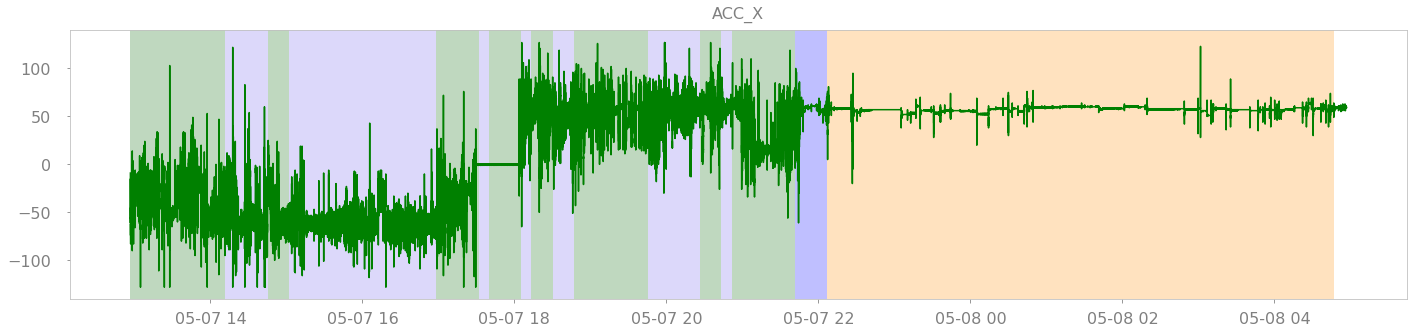

CPU times: user 6.89 s, sys: 452 ms, total: 7.34 s
Wall time: 6.84 s


In [4]:
%%time

# Visualize second-layer PFSAs with respect to the original data

import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams["figure.figsize"] = (20, 5)

def graph_data(pipelines, data, start_ts, end_ts, agitation_starts):
    for i, category in enumerate(DATA_CATEGORIES):

        NEW_WINDOW_SIZE = pipelines[i].window_size
        NEW_WINDOW_OVERLAP = pipelines[i].window_overlap
        pipelines[i].anomaly_sensitivity = 1
        predictions = pd.DataFrame(pipelines[i].predict())

        data["ts"] = pd.DataFrame([datetime.fromtimestamp(start_ts + (j / hz[i])) for j in range(data[category].shape[0])])
        df = pd.concat([data[category], data["ts"]], axis=1)
        df.columns = ["data", "ts"]

        plt.subplot(len(DATA_CATEGORIES), 1, i+1)
        plt.plot(df["ts"], df["data"], color="green", markersize=2, zorder=1)

        # highlight true anomalies
        for ts in agitation_starts:
            if ts > end_ts:
                continue
            beg = datetime.fromtimestamp(ts)
            end = datetime.fromtimestamp(ts + 60)
            plt.axvspan(beg, end, color='black', alpha=0.8, lw=0, zorder=3)

        # highlight non-anomalies by cluster
        colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan', "navy", "yellow", "darkgray", "white", "purple"]
        non_anomalies = predictions
        for index in non_anomalies.index:
            base = (NEW_WINDOW_SIZE- NEW_WINDOW_OVERLAP) * (WINDOW_SIZE[i] - WINDOW_OVERLAP[i]) * index
            next_base = base + NEW_WINDOW_SIZE * (WINDOW_SIZE[i] - WINDOW_OVERLAP[i])
            next_base = (NEW_WINDOW_SIZE - NEW_WINDOW_OVERLAP) * (WINDOW_SIZE[i] - WINDOW_OVERLAP[i]) * (index + 1)
            beg = data["ts"].iloc[min(data["ts"].shape[0] - 1, base)][0]
            end = data["ts"].iloc[min(data["ts"].shape[0] - 1, next_base)][0] 
            color = colors[pipelines[i].closest_match[index]]
            plt.axvspan(beg, end, color=color, alpha=0.25, lw=0, zorder=0)

        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        ax.tick_params(axis='x', colors='.5')    
        ax.tick_params(axis='y', colors='.5', pad=15)  
        ax.yaxis.offsetText.set_fontsize(16)
        ax.spines['bottom'].set_color('.75')
        ax.spines['top'].set_color('.75') 
        ax.spines['right'].set_color('.75')
        ax.spines['left'].set_color('.75')
        ax.set_title(f"{category}", fontsize=16, y=1.02, color='.5')

    plt.tight_layout(pad=2)
    plt.show()
    
graph_data(second_layer_pipelines, data, new_train_start_ts, new_train_end_ts, train_agitation_starts)

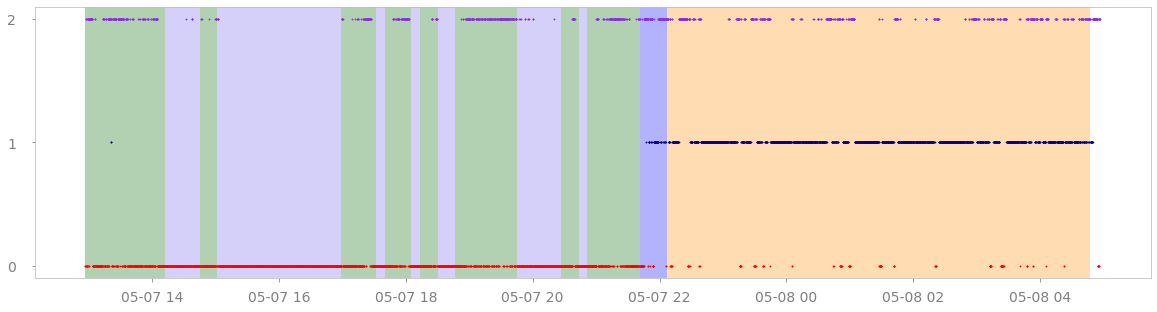

In [5]:
# Visualize second-layer PFSAs (highlights) in relation to first-layer PFSAs (dots)

plt.rcParams["figure.figsize"] = (20, 5)

for category in DATA_CATEGORIES:
    data["ts"] = pd.DataFrame(
        [
            datetime.fromtimestamp(new_train_start_ts + ((j * (pipeline_1.window_size - pipeline_1.window_overlap)) / hz[0]))
            for j in range(len(pipeline_1.closest_match)//1)
        ]
    )
    df = pd.concat([pd.DataFrame(pipeline_1.closest_match), data["ts"]], axis=1).dropna()
    df.columns = ["data", "ts"]

    colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan', "navy", "yellow", "darkgray", "white", "purple"]
    scatter_colors = ["red", "navy", "blueviolet"]

#     plt.subplot(len(DATA_CATEGORIES), 1, i+1)
    for cluster, indices in df.groupby("data"):
        plt.plot(indices["ts"], indices["data"], markersize=0.8, linestyle='', marker='o', color=scatter_colors[cluster])

    pipeline_2.predict(pipeline_1.closest_match)
    for index, cluster in enumerate(pipeline_2.closest_match):
        base = (pipeline_2.window_size- pipeline_2.window_overlap) * index
        next_base = base + pipeline_2.window_size 
        next_base = (pipeline_2.window_size - pipeline_2.window_overlap) * (index + 1)
        beg = data["ts"].iloc[min(data["ts"].shape[0] - 1, base)][0]
        end = data["ts"].iloc[min(data["ts"].shape[0] - 1, next_base)][0] 
        color = colors[pipeline_2.closest_match[index]]
        plt.axvspan(beg, end, color=color, alpha=0.3, lw=0, zorder=0)
    
    
ax = plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=14, y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.yticks(np.arange(0, pipeline_1.n_clusters, 1))
ax.tick_params(axis='x', colors='.5')    
ax.tick_params(axis='y', colors='.5', pad=15)  
ax.yaxis.offsetText.set_fontsize(16)
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')

In [6]:
from IPython.display import Image, display
from IPython.core.display import HTML
for i, pipeline in enumerate(second_layer_pipelines):
    print(DATA_CATEGORIES[i])
    for i, file in enumerate(pipeline.cluster_PFSA_pngs):
        print(f"Cluster {i} PFSA")
        display(Image(url=f"{file}.png", width=300))

ACC_X
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA
